ETF DASHBOARD V.2.0

# | AlgoTrader 
- Algorithmic Financial Trading with Deep Convolutional Neural Networks
- *inspired by paper "Algorithmic Financial Trading with Deep Convolutional Neural Networks: Time Series to Image Conversion Approach"
- implemenetation reference for neural network prediction model: https://towardsdatascience.com/stock-market-action-prediction-with-convnet-8689238feae3

In [23]:
# Author: Ken Lee 2020.01.12
# Our Library
import ETFFundamentalData as finData
import ETFHistoryDownload as hist
import ETFStockAnalytics as analytic
import ETFPerformanceForecast as perf
# Common Library
import sqlalchemy as sql
import hvplot.pandas
import numpy as np
from pandas import ExcelWriter
import pandas as pd
#import datetime
import time
import os
from pathlib import Path
import logging
from dateutil.relativedelta import relativedelta
from datetime import datetime
import pickle 
import numpy as np
from tqdm import tqdm_notebook as tqdm
from IPython.core.interactiveshell import InteractiveShell
# DB Connection
eft_data_connection_string = 'sqlite:///./Resources/etf.db'
our_portfolio_export = Path('./Resources/our_portfolio.csv')
etf_data_engine = sql.create_engine(eft_data_connection_string, echo=True)
# IF REQUIRED TO RELOAD - SET TRUE
RELOAD_DATA = False
DEBUG_MODE = False

## STEP1. LOAD Fresh_rolling_train Data for ML Training

In [24]:
# Load Fresh_rolling_train Data for ML Training
sql_query = """
SELECT distinct symbol as symbol
FROM 'OUR_PORTFOLIO_LIST'
UNION
SELECT 'SPY'
"""
our_portfolio_list = pd.read_sql_query(sql_query, eft_data_connection_string)
our_portfolio_list = our_portfolio_list.set_index('symbol')  
symbol_list = []
for symbol in our_portfolio_list.index:
    symbol_list.append(symbol)


print(symbol_list)

['ACN', 'AMAT', 'AMD', 'APPS', 'ARWR', 'CBRE', 'DE', 'DHR', 'DOCU', 'EL', 'EPAM', 'FB', 'GE', 'GOOG', 'GOOGL', 'GS', 'IRT', 'KEYS', 'KLAC', 'LCII', 'LIN', 'LRCX', 'LSCC', 'LULU', 'MPWR', 'MRVL', 'MSFT', 'MU', 'NEO', 'NXPI', 'PAYC', 'PLD', 'POOL', 'QCOM', 'QQQ', 'QRVO', 'RH', 'ROKU', 'SAIA', 'SEDG', 'SNBR', 'SNPS', 'SPY', 'STX', 'SWKS', 'TER', 'TGT', 'TSLA', 'UPS', 'VICR', 'WST', 'XLK', 'YETI']


In [77]:
def load_train_data_from_csv(p_symbol):
    l_df = pd.read_csv("./outputs/fresh_rolling_train/df_"+p_symbol+".csv")
    l_df['labels'] = l_df['labels'].astype(np.int8)
    #l_df = l_df.set_index('timestamp')
    if 'dividend_amount' in l_df.columns:
        l_df.drop(columns=['dividend_amount', 'split_coefficient'], inplace=True)
    return l_df


In [26]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

def get_sample_weights(y):
    """
    calculate the sample weights based on class weights. Used for models with
    imbalanced data and one hot encoding prediction.

    params:
        y: class labels as integers
    """

    y = y.astype(int)  # compute_class_weight needs int labels
    class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
    
    print("real class weights are {}".format(class_weights), np.unique(y))
    print("value_counts", np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
        # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

    return sample_weights

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

def f1_weighted(y_true, y_pred):
    y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)  # can use conf_mat[0, :], tf.slice()
    # precision = TP/TP+FP, recall = TP/TP+FN
    rows, cols = conf_mat.get_shape()
    size = y_true_class.get_shape()[0]
    precision = tf.constant([0, 0, 0])  # change this to use rows/cols as size
    recall = tf.constant([0, 0, 0])
    class_counts = tf.constant([0, 0, 0])

    def get_precision(i, conf_mat):
        print("prec check", conf_mat, conf_mat[i, i], tf.reduce_sum(conf_mat[:, i]))
        precision[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[:, i]))
        recall[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[i, :]))
        tf.add(i, 1)
        return i, conf_mat, precision, recall

    def tf_count(i):
        elements_equal_to_value = tf.equal(y_true_class, i)
        as_ints = tf.cast(elements_equal_to_value, tf.int32)
        count = tf.reduce_sum(as_ints)
        class_counts[i].assign(count)
        tf.add(i, 1)
        return count

    def condition(i, conf_mat):
        return tf.less(i, 3)

    i = tf.constant(3)
    i, conf_mat = tf.while_loop(condition, get_precision, [i, conf_mat])

    i = tf.constant(3)
    c = lambda i: tf.less(i, 3)
    b = tf_count(i)
    tf.while_loop(c, b, [i])

    weights = tf.math.divide(class_counts, size)
    numerators = tf.math.multiply(tf.math.multiply(precision, recall), tf.constant(2))
    denominators = tf.math.add(precision, recall)
    f1s = tf.math.divide(numerators, denominators)
    weighted_f1 = tf.reduce_sum(f.math.multiply(f1s, weights))
    return weighted_f1

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall 
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))



In [75]:
from functools import *
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import AUC
def f1_custom(y_true, y_pred):
    y_t = np.argmax(y_true, axis=1)
    y_p = np.argmax(y_pred, axis=1)
    f1_score(y_t, y_p, labels=None, average='weighted', sample_weight=None, zero_division='warn')

def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    
    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],
                           params["conv2d_layers"]["conv2d_kernel_size_1"],
                           strides=params["conv2d_layers"]["conv2d_strides_1"],
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]), 
                           padding='same',activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(x_train[0].shape[0],
                                        x_train[0].shape[1], x_train[0].shape[2]))
    model.add(conv2d_layer1)
    if params["conv2d_layers"]['conv2d_mp_1'] > 1:
        model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_1']))
        
    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))
    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"],
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='same',activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)
        
        if params["conv2d_layers"]['conv2d_mp_2'] > 1:
            model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_2']))
        
        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))
    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu', 
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(3, activation='softmax'))
    
    if params["optimizer"] == 'rmsprop':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    elif params["optimizer"] == 'sgd':
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    elif params["optimizer"] == 'adam':
        optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])
    
    return model

def check_baseline(pred, y_test):
    print("size of test set", len(y_test))
    e = np.equal(pred, y_test)
    print("TP class counts", np.unique(y_test[e], return_counts=True))
    print("True class counts", np.unique(y_test, return_counts=True))
    print("Pred class counts", np.unique(pred, return_counts=True))
    holds = np.unique(y_test, return_counts=True)[1][2]  # number 'hold' predictions
    print("baseline acc:", (holds/len(y_test)*100))
    

,timestamp,open,high,low,close,adjusted_close,volume,rsi_6,rsi_7,rsi_8,...,eom_19,eom_20,eom_21,eom_22,eom_23,eom_24,eom_25,eom_26,volume_delta,labels
0,2017-05-17,122.20,123.07,120.34,120.45,120.45,1570846,40.277319,38.254507,44.607843,...,-184.219204,-184.219204,-184.219204,-184.219204,-184.219204,-184.219204,-184.219204,-184.219204,-18042.0,2
1,2017-05-18,120.86,121.03,119.41,120.40,120.40,1452341,43.884892,43.740663,40.753997,...,-165.642917,-165.642917,-165.642917,-165.642917,-165.642917,-165.642917,-165.642917,-165.642917,-118505.0,1
2,2017-05-19,121.01,121.21,120.19,120.96,120.96,1756304,49.199608,49.865664,49.597424,...,27.876723,27.876723,27.876723,27.876723,27.876723,27.876723,27.876723,27.876723,303963.0,2
3,2017-05-22,121.60,122.84,121.22,122.68,122.68,1410538,64.434060,61.205821,61.489475,...,152.750227,152.750227,152.750227,152.750227,152.750227,152.750227,152.750227,152.750227,-345766.0,2
4,2017-05-23,122.86,123.07,121.80,122.14,122.14,1100589,56.994161,57.822278,55.348280,...,46.734067,46.734067,46.734067,46.734067,46.734067,46.734067,46.734067,46.734067,-309949.0,2


Total number of features 447
train_split = 0.8
Shape of x, y train/cv/test (748, 447) (748,) (187, 447) (187,) (234, 447) (234,)


SelectKBest(k=320)

('open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'rsi_6', 'rsi_7', 'rsi_8', 'rsi_9', 'rsi_10', 'rsi_11', 'rsi_12', 'rsi_13', 'rsi_14', 'rsi_15', 'rsi_16', 'rsi_17', 'rsi_18', 'rsi_19', 'rsi_20', 'rsi_21', 'rsi_22', 'rsi_23', 'rsi_24', 'rsi_25', 'rsi_26', 'wr_6', 'wr_7', 'wr_8', 'wr_9', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'wr_14', 'wr_15', 'wr_16', 'wr_17', 'wr_18', 'wr_19', 'wr_20', 'wr_21', 'wr_22', 'wr_23', 'wr_24', 'wr_25', 'wr_26', 'mfi_6', 'mfi_7', 'mfi_8', 'mfi_9', 'mfi_10', 'mfi_11', 'mfi_12', 'mfi_13', 'mfi_14', 'mfi_15', 'mfi_16', 'mfi_17', 'mfi_18', 'mfi_19', 'mfi_20', 'mfi_21', 'mfi_22', 'mfi_23', 'mfi_24', 'mfi_25', 'mfi_26', 'roc_6', 'roc_7', 'roc_8', 'roc_9', 'roc_10', 'roc_11', 'roc_12', 'roc_13', 'roc_14', 'roc_15', 'roc_16', 'roc_17', 'roc_18', 'roc_19', 'roc_20', 'roc_21', 'roc_22', 'roc_23', 'roc_24', 'roc_25', 'roc_26', 'cmf_6', 'cmf_7', 'cmf_8', 'cmf_9', 'cmf_10', 'cmf_11', 'cmf_12', 'cmf_13', 'cmf_14', 'cmf_15', 'cmf_16', 'cmf_17', 'cmf_18', 'cmf_19', 

SelectKBest(k=320,
            score_func=<function mutual_info_classif at 0x000001A05FF4FCA8>)

320 ('open', 'rsi_6', 'rsi_7', 'rsi_8', 'rsi_9', 'rsi_10', 'rsi_11', 'rsi_12', 'rsi_13', 'rsi_14', 'rsi_15', 'rsi_16', 'rsi_17', 'rsi_18', 'rsi_19', 'rsi_20', 'rsi_21', 'rsi_22', 'rsi_23', 'rsi_24', 'rsi_25', 'rsi_26', 'wr_6', 'wr_7', 'wr_8', 'wr_9', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'wr_14', 'wr_15', 'wr_16', 'wr_17', 'wr_18', 'wr_19', 'wr_20', 'wr_21', 'wr_22', 'wr_23', 'wr_24', 'wr_25', 'wr_26', 'mfi_6', 'mfi_7', 'mfi_8', 'mfi_9', 'mfi_10', 'mfi_11', 'mfi_12', 'mfi_13', 'mfi_14', 'mfi_15', 'mfi_16', 'mfi_17', 'mfi_18', 'mfi_19', 'mfi_20', 'mfi_21', 'mfi_22', 'mfi_23', 'mfi_24', 'mfi_26', 'roc_6', 'roc_7', 'roc_8', 'roc_9', 'roc_10', 'roc_11', 'roc_12', 'roc_13', 'roc_14', 'roc_15', 'roc_16', 'roc_17', 'roc_18', 'roc_19', 'roc_20', 'roc_21', 'roc_22', 'roc_23', 'roc_24', 'roc_25', 'roc_26', 'cmf_6', 'cmf_7', 'cmf_9', 'cmf_11', 'cmf_12', 'cmf_13', 'cmf_14', 'cmf_15', 'cmf_16', 'cmf_17', 'cmf_19', 'cmf_20', 'cmf_21', 'cmf_24', 'cmf_25', 'cmf_26', 'cmo_6', 'cmo_7', 'cmo_8', 'cmo_9', '

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_268_class_2')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_320_class_2')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_367_class_2')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_591_class_2')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_615_class_2')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_397_class_0')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_376_class_2')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_409_class_2')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'image_195_class_0')

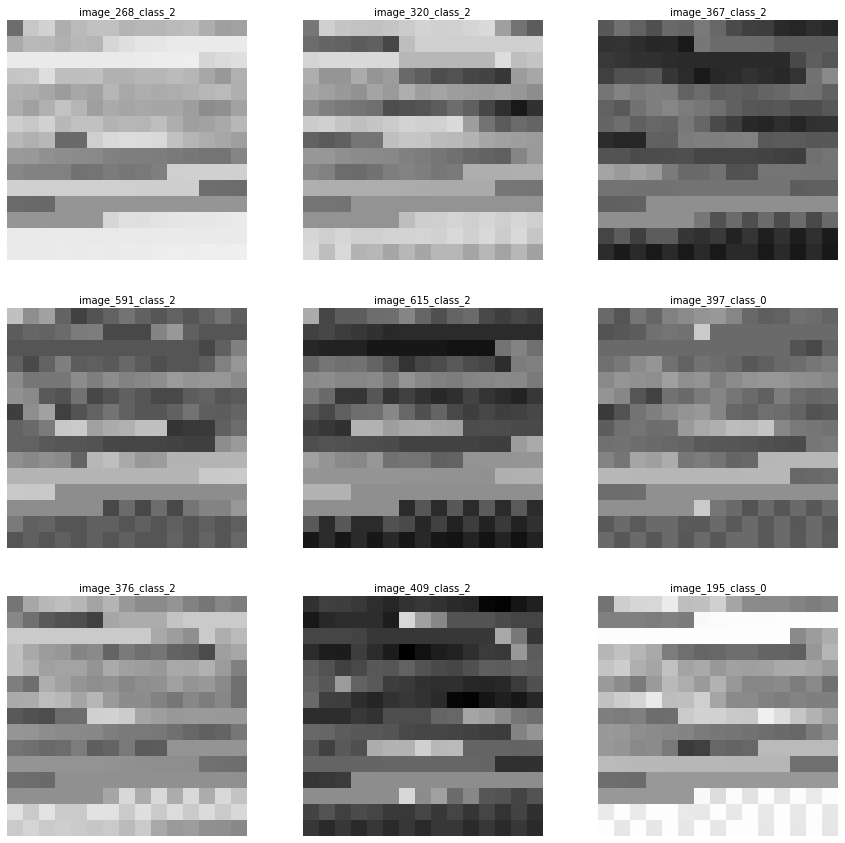

Training with params {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 10, 'lr': 0.001, 'optimizer': 'adam'}
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/10
12/12 [==============================] - ETA: 0s - loss: 1.1132 - accuracy: 0.4291 - f1_metric: 0.2162
Epoch 00001: val_f1_metric improved from -inf to 0.00000, saving model to .\best_model_keras
INFO:tensorflow:Assets written to: .\best_model_keras\assets
12/12 [==============================] - 15s 947ms/

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

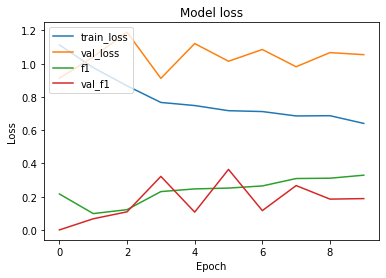

keras evaluate= [1.0381938219070435, 0.5085470080375671, 0.44547122716903687]
size of test set 234
TP class counts (array([0, 1, 2], dtype=int64), array([  1,   9, 109], dtype=int64))
True class counts (array([0, 1, 2], dtype=int64), array([ 13,   9, 212], dtype=int64))
Pred class counts (array([0, 1, 2], dtype=int64), array([  7, 106, 121], dtype=int64))
baseline acc: 90.5982905982906
[[  1   0  12]
 [  0   9   0]
 [  6  97 109]]
F1 score (weighted) 0.6046815488844474
F1 score (macro) 0.3037254645950298
F1 score (micro) 0.5085470085470085
cohen's Kappa 0.04094942799101886
Recall of class 0 = 0.08
Recall of class 1 = 1.0
Recall of class 2 = 0.51
Recall avg 0.53


In [80]:
# Run ML
for symbol in symbol_list:

    if symbol == 'ACN':
    strategy_type = 'original'
    df = load_train_data_from_csv(symbol)
    display(df.head())
    
#1 Split data into Training, Validation and Test
    from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
    from sklearn.model_selection import train_test_split
    from collections import Counter
    
    list_features = list(df.loc[:, 'open':'eom_26'].columns)
    print('Total number of features', len(list_features))
    
    x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open':'eom_26'].values, df['labels'].values, train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=False) #, stratify=df['labels'].values)
    if 0.7*x_train.shape[0] < 2500:
        train_split = 0.8
    else:
        train_split = 0.7
    print('train_split =',train_split)
    x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=False) #, stratify=y_train)
    mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
    x_train = mm_scaler.fit_transform(x_train)
    x_cv = mm_scaler.transform(x_cv)
    x_test = mm_scaler.transform(x_test)

    x_main = x_train.copy()
    print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))
    
    
# train method selection - if all then add both anova and mutual info)
    num_features = 225  # should be a perfect square
    selection_method = 'all'
    topk = 320 if selection_method == 'all' else num_features
    
    from operator import itemgetter
    from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

    if selection_method == 'anova' or selection_method == 'all':
        select_k_best = SelectKBest(f_classif, k=topk)
        if selection_method != 'all':
            x_train = select_k_best.fit_transform(x_main, y_train)
            x_cv = select_k_best.transform(x_cv)
            x_test = select_k_best.transform(x_test)
        else:
            select_k_best.fit(x_main, y_train)
    
        selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
        print(selected_features_anova)
        print(select_k_best.get_support(indices=True))
        print("****************************************")
    
    if selection_method == 'mutual_info' or selection_method == 'all':
        select_k_best = SelectKBest(mutual_info_classif, k=topk)
        if selection_method != 'all':
            x_train = select_k_best.fit_transform(x_main, y_train)
            x_cv = select_k_best.transform(x_cv)
            x_test = select_k_best.transform(x_test)
        else:
            select_k_best.fit(x_main, y_train)

        selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
        print(len(selected_features_mic), selected_features_mic)
        print(select_k_best.get_support(indices=True))
    
    if selection_method == 'all':
        common = list(set(selected_features_anova).intersection(selected_features_mic))
        print("common selected featues", len(common), common)
        if len(common) < num_features:
            raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
        feat_idx = []
        for c in common:
            feat_idx.append(list_features.index(c))
        feat_idx = sorted(feat_idx[0:225])
        print(feat_idx)

    if selection_method == 'all':
        x_train = x_train[:, feat_idx]
        x_cv = x_cv[:, feat_idx]
        x_test = x_test[:, feat_idx]

    print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, 
                                                             y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))
    
    _labels, _counts = np.unique(y_train, return_counts=True)
    print("percentage of class 0 = {}, class 1 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100))
    
    get_custom_objects().update({"f1_metric": f1_metric, "f1_weighted": f1_weighted})
    
    sample_weights = get_sample_weights(y_train)
    print("Test sample_weights")
    rand_idx = np.random.randint(0, 600, 30) #KL: Reduce the size to 500
    print(y_train[rand_idx])
    print(sample_weights[rand_idx])
    
    one_hot_enc = OneHotEncoder(sparse=False, categories='auto')  # , categories='auto'
    y_train = one_hot_enc.fit_transform(y_train.reshape(-1, 1))
    print("y_train",y_train.shape)
    y_cv = one_hot_enc.transform(y_cv.reshape(-1, 1))
    y_test = one_hot_enc.transform(y_test.reshape(-1, 1))
    
    dim = int(np.sqrt(num_features))
    x_train = reshape_as_image(x_train, dim, dim)
    x_cv = reshape_as_image(x_cv, dim, dim)
    x_test = reshape_as_image(x_test, dim, dim)
    # adding a 1-dim for channels (3)
    x_train = np.stack((x_train,) * 3, axis=-1)
    x_test = np.stack((x_test,) * 3, axis=-1)
    x_cv = np.stack((x_cv,) * 3, axis=-1)
    print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))
    
    from matplotlib import pyplot as plt
    %matplotlib inline
   
    fig = plt.figure(figsize=(15, 15))
    columns = rows = 3
    for i in range(1, columns*rows +1):
        index = np.random.randint(len(x_train))
        img = x_train[index]
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.imshow(img)
    plt.show()
    
    from tensorflow.keras.models import Sequential, load_model, Model
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
    from tensorflow.keras import optimizers
    from tensorflow.keras.regularizers import l2, l1, l1_l2
    from tensorflow.keras.initializers import RandomUniform, RandomNormal
    from tensorflow.keras.models import load_model
    from tensorflow.keras import regularizers

    params = {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 
                                               'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 
                                               'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 
                                               'kernel_regularizer_2': 0.0, 'layers': 'two'}, 
           'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
           'epochs': 10, 'lr': 0.001, 'optimizer': 'adam'}


    from IPython.display import SVG
    from tensorflow.keras.utils import plot_model
    from keras.utils.vis_utils import model_to_dot

    model = create_model_cnn(params)
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

    import os

    best_model_path = os.path.join('.', 'best_model_keras')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001)
    rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=20, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001)
    mcp = ModelCheckpoint(best_model_path, monitor='val_f1_metric', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='max', period=1)  # val_f1_metric
    
    history = model.fit(x_train, y_train, epochs=params['epochs'], verbose=1,
                            batch_size=64, shuffle=True,
                            # validation_split=0.3,
                            validation_data=(x_cv, y_cv),
                            callbacks=[mcp, rlp, es]
                            , sample_weight=sample_weights)    
    
    from matplotlib import pyplot as plt
    %matplotlib inline
    InteractiveShell.ast_node_interactivity = "last"

    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['f1_metric'])
    plt.plot(history.history['val_f1_metric'])

    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train_loss', 'val_loss', 'f1', 'val_f1'], loc='upper left')
    plt.show()
    
    from sklearn.metrics import confusion_matrix, roc_auc_score, cohen_kappa_score
    import seaborn as sns

    model = load_model(best_model_path)
    test_res = model.evaluate(x_test, y_test, verbose=0)
    print("keras evaluate=", test_res)
    pred = model.predict(x_test)
    pred_classes = np.argmax(pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    check_baseline(pred_classes, y_test_classes)
    conf_mat = confusion_matrix(y_test_classes, pred_classes)
    print(conf_mat)
    labels = [0,1,2]

    f1_weighted = f1_score(y_test_classes, pred_classes, labels=None, 
         average='weighted', sample_weight=None)
    print("F1 score (weighted)", f1_weighted)
    print("F1 score (macro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='macro', sample_weight=None))
    print("F1 score (micro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='micro', sample_weight=None))  # weighted and micro preferred in case of imbalance

# https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa --> supports multiclass; ref: https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
    print("cohen's Kappa", cohen_kappa_score(y_test_classes, pred_classes))

    recall = []
    for i, row in enumerate(conf_mat):
        recall.append(np.round(row[i]/np.sum(row), 2))
        print("Recall of class {} = {}".format(i, recall[i]))
    print("Recall avg", sum(recall)/len(recall))